In [1]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import csv
import numpy as np
import scipy
from scipy.optimize import curve_fit
from enum import Enum
import itertools
from tqdm import tqdm
import torch.utils.data

### Resnet model architecture with different numbers of layers

In [2]:
# The following code is from: https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable
import csv


__all__ = ['ResNet', 'resnet18', 'resnet20', 'resnet32', 'resnet44','resnet50', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resntet18():
     return ResNet(BasicBlock, [3, 3, 2])
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])
def resnet50():
    return ResNet(BasicBlock, [9, 9, 6])
def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])

def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])

### The following block of code trains CIFAR10 with ResNet56 model architecture and logs the train loss. To train the model with different Resnet model in terms of number of layers, define the model using one of the above resnet functions. GPU is required to run the training job.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm import tqdm

def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())
def train(model, criterion, optimizer, dataloader, device):
    model.train()
    train_loss = 0
    total = 0
    running_accuracy = 0
    for image, label in dataloader:
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        train_loss += loss.item()
        total += label.size(0)
        loss.backward()
        optimizer.step()
        running_accuracy += accuracy(output, label)
    acc = (running_accuracy / total) * 128
    return train_loss / total, acc

def test(model, criterion, dataloader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            test_loss += loss.item()
            pred = torch.max(pred.data, 1)[1]
            total += labels.size(0)
            correct += (pred == labels).sum().item()
        accuracy = correct / total
    return test_loss / total, accuracy

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True,)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,)

# define loss function (criterion) and optimizer
model = resnet56()
device = 'cuda'
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_losses = []
epochs = 350

for i in tqdm(range(epochs)):
    train_loss, acc = train(model, criterion, optimizer, train_loader, device)
    train_losses.append(train_loss)
# uncomment the below part for problem 4.2
#     print('train accuracy:', acc)
#     if acc >= 0.92:
#         break
    

torch.save(train_losses, './T4_resnet56_train_losses.pth')

In [3]:
resnet18_t4 = torch.load('./loss/t4_resnet18_train_losses.pth')
resnet18_rtx8000 = torch.load('./loss/rtx8000_resnet18_train_losses.pth')
resnet18_v100 = torch.load('./loss/v100_resnet18_train_losses.pth')
resnet18_a100 = torch.load('./loss/a100_resnet18_train_losses.pth')

resnet20_t4 = torch.load('./loss/t4_resnet20_train_losses.pth')
resnet20_rtx8000 = torch.load('./loss/rtx8000_resnet20_train_losses.pth')
resnet20_v100 = torch.load('./loss/v100_resnet20_train_losses.pth')
resnet20_a100 = torch.load('./loss/a100_resnet20_train_losses.pth')

resnet32_t4 = torch.load('./loss/t4_resnet32_train_losses.pth')
resnet32_rtx8000 = torch.load('./loss/rtx8000_resnet32_train_losses.pth')
resnet32_v100 = torch.load('./loss/v100_resnet32_train_losses.pth')
resnet32_a100 = torch.load('./loss/a100_resnet32_train_losses.pth')

resnet44_t4 = torch.load('./loss/t4_resnet44_train_losses.pth')
resnet44_rtx8000 = torch.load('./loss/rtx8000_resnet44_train_losses.pth')
resnet44_v100 = torch.load('./loss/v100_resnet44_train_losses.pth')
resnet44_a100 = torch.load('./loss/a100_resnet44_train_losses.pth')

resnet56_t4 = torch.load('./loss/T4_resnet56_train_losses.pth')
resnet56_rtx8000 = torch.load('./loss/rtx8000_resnet56_train_losses.pth')
resnet56_v100 = torch.load('./loss/v100_resnet56_train_losses.pth')
resnet56_a100 = torch.load('./loss/a100_resnet56_train_losses.pth')

resnet110_t4 = torch.load('./loss/t4_resnet110_train_losses.pth')
resnet110_rtx8000 = torch.load('./loss/rtx8000_resnet110_train_losses.pth')
resnet110_v100 = torch.load('./loss/v100_resnet110_train_losses.pth')
resnet110_a100 = torch.load('./loss/a100_resnet110_train_losses.pth')


### The logged training loss per epoch for each training job:  

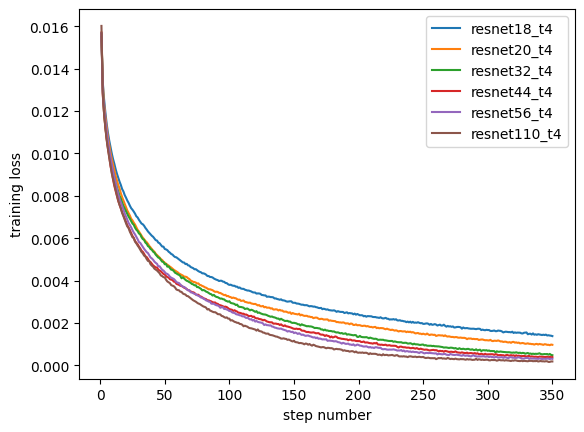

In [4]:
plt.plot(range(1, 1+len(resnet18_t4)), resnet18_t4, label='resnet18_t4')
plt.plot(range(1, 1+len(resnet20_t4)), resnet20_t4, label='resnet20_t4')
plt.plot(range(1, 1+len(resnet32_t4)), resnet32_t4, label='resnet32_t4')
plt.plot(range(1, 1+len(resnet44_t4)), resnet44_t4, label='resnet44_t4')
plt.plot(range(1, 1+len(resnet56_t4)), resnet56_t4, label='resnet56_t4')
plt.plot(range(1, 1+len(resnet110_t4)), resnet110_t4, label='resnet110_t4')
plt.xlabel('step number')
plt.ylabel('training loss')
plt.legend()
plt.show()

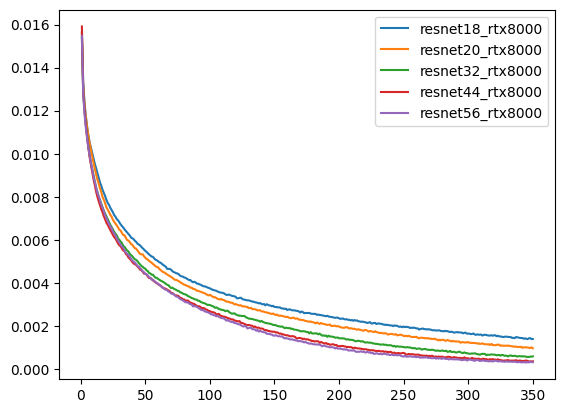

In [5]:
plt.plot(range(1, 1+len(resnet18_rtx8000)), resnet18_rtx8000, label='resnet18_rtx8000')
plt.plot(range(1, 1+len(resnet20_rtx8000)), resnet20_rtx8000, label='resnet20_rtx8000')
plt.plot(range(1, 1+len(resnet32_rtx8000)), resnet32_rtx8000, label='resnet32_rtx8000')
plt.plot(range(1, 1+len(resnet44_rtx8000)), resnet44_rtx8000, label='resnet44_rtx8000')
plt.plot(range(1, 1+len(resnet56_rtx8000)), resnet56_rtx8000, label='resnet56_rtx8000')
plt.legend()
plt.show()

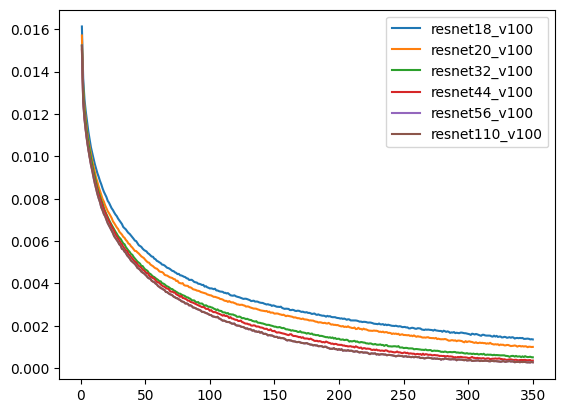

In [6]:
plt.plot(range(1, 1+len(resnet18_v100)), resnet18_v100, label='resnet18_v100')
plt.plot(range(1, 1+len(resnet20_v100)), resnet20_v100, label='resnet20_v100')
plt.plot(range(1, 1+len(resnet32_v100)), resnet32_v100, label='resnet32_v100')
plt.plot(range(1, 1+len(resnet44_v100)), resnet44_v100, label='resnet44_v100')
plt.plot(range(1, 1+len(resnet56_v100)), resnet56_v100, label='resnet56_v100')
plt.plot(range(1, 1+len(resnet110_v100)), resnet56_v100, label='resnet110_v100')
plt.legend()
plt.show()

### We use the Scipy's curve fit function for regression based on effective step number and trainin loss. 

In [7]:
def onlinefitting(k, b0, b1, b2):
    return 1/(b0*k + b1) + b2

popt_resnet18_t4, pcov_resnet18_t4 = curve_fit(onlinefitting, range(1, 351), resnet18_t4)
popt_resnet20_t4, pcov_resnet20_t4 = curve_fit(onlinefitting, range(1, 351), resnet20_t4)
popt_resnet32_t4, pcov_resnet32_t4 = curve_fit(onlinefitting, range(1, 351), resnet32_t4)
popt_resnet44_t4, pcov_resnet44_t4 = curve_fit(onlinefitting, range(1, 351), resnet44_t4)
popt_resnet56_t4, pcov_resnet56_t4 = curve_fit(onlinefitting, range(1, 351), resnet56_t4)
popt_resnet110_t4, pcov_resnet110_t4 = curve_fit(onlinefitting, range(1, 351), resnet110_t4)

popt_resnet18_rtx8000, pcov_resnet18_rtx8000 = curve_fit(onlinefitting, range(1, 351), resnet18_rtx8000)
popt_resnet20_rtx8000, pcov_resnet20_rtx8000 = curve_fit(onlinefitting, range(1, 351), resnet20_rtx8000)
popt_resnet32_rtx8000, pcov_resnet32_rtx8000 = curve_fit(onlinefitting, range(1, 351), resnet32_rtx8000)
popt_resnet44_rtx8000, pcov_resnet44_rtx8000 = curve_fit(onlinefitting, range(1, 351), resnet44_rtx8000)
popt_resnet56_rtx8000, pcov_resnet56_rtx8000 = curve_fit(onlinefitting, range(1, 351), resnet56_rtx8000)
popt_resnet110_rtx8000, _ = curve_fit(onlinefitting, range(1, 351), resnet110_rtx8000)

popt_resnet18_v100, pcov_resnet18_v100 = curve_fit(onlinefitting, range(1, 351), resnet18_v100)
popt_resnet20_v100, pcov_resnet20_v100 = curve_fit(onlinefitting, range(1, 351), resnet20_v100)
popt_resnet32_v100, pcov_resnet32_v100 = curve_fit(onlinefitting, range(1, 351), resnet32_v100)
popt_resnet44_v100, pcov_resnet44_v100 = curve_fit(onlinefitting, range(1, 351), resnet44_v100)
popt_resnet56_v100, pcov_resnet56_v100 = curve_fit(onlinefitting, range(1, 351), resnet56_v100)
popt_resnet110_v100, pcov_resnet110_v100 = curve_fit(onlinefitting, range(1, 351), resnet110_v100)

popt_resnet18_a100, pcov_resnet18_a100 = curve_fit(onlinefitting, range(1, 351), resnet18_a100)
popt_resnet20_a100, pcov_resnet20_a100 = curve_fit(onlinefitting, range(1, 351), resnet20_a100)
popt_resnet32_a100, pcov_resnet32_a100 = curve_fit(onlinefitting, range(1, 351), resnet32_a100)
popt_resnet44_a100, pcov_resnet44_a100 = curve_fit(onlinefitting, range(1, 351), resnet44_a100)
popt_resnet56_a100, pcov_resnet56_a100 = curve_fit(onlinefitting, range(1, 351), resnet56_a100)
popt_resnet110_a100, pcov_resnet110_a100 = curve_fit(onlinefitting, range(1, 351), resnet110_a100)

# an example of learned prameters for training CIFAR10 with different 
print('Learned parameters for resnet18_a100', popt_resnet18_a100)

Learned parameters for resnet18_a100 [2.59809639e+00 7.75501086e+01 7.12157922e-04]


### Creating x_train and y_train for the final predictive model. The goal is to learn the beta parameters as a function of type of GPU and the number of layers in Resnet model. 

In [8]:
class Device(Enum):
    t4 = 0
    rtx8000 = 1
    v100 = 2
    a100 = 3
device = [0, 1, 2, 3]
layers = [18, 20, 32, 44, 56, 110]
lst = [layers, device]
x_train = [p for p in itertools.product(*lst)]
x_train = [list(i) for i in x_train]
x_train = np.asarray(x_train)
y_train = [popt_resnet18_t4, popt_resnet18_rtx8000, popt_resnet18_v100, popt_resnet18_a100, popt_resnet20_t4, popt_resnet20_rtx8000, popt_resnet20_v100, popt_resnet20_a100,
           popt_resnet32_t4, popt_resnet32_rtx8000, popt_resnet32_v100, popt_resnet32_a100, popt_resnet44_t4, popt_resnet44_rtx8000, popt_resnet44_v100, popt_resnet44_a100,
           popt_resnet56_t4,popt_resnet56_rtx8000, popt_resnet56_v100, popt_resnet56_a100, popt_resnet110_t4, popt_resnet110_rtx8000, popt_resnet110_v100, popt_resnet110_a100]
y_train = np.asarray(y_train)

In [9]:
x_train

array([[ 18,   0],
       [ 18,   1],
       [ 18,   2],
       [ 18,   3],
       [ 20,   0],
       [ 20,   1],
       [ 20,   2],
       [ 20,   3],
       [ 32,   0],
       [ 32,   1],
       [ 32,   2],
       [ 32,   3],
       [ 44,   0],
       [ 44,   1],
       [ 44,   2],
       [ 44,   3],
       [ 56,   0],
       [ 56,   1],
       [ 56,   2],
       [ 56,   3],
       [110,   0],
       [110,   1],
       [110,   2],
       [110,   3]])

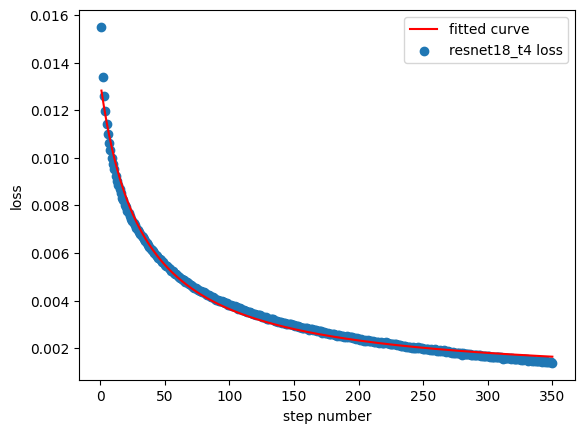

In [10]:
# visualizing the fitted curve for training CIFAR10 with Resnet18 using T4 GPU
y = []
for p in y_train:
    val = onlinefitting(range(1, 351), p[0], p[1], p[2])
    y.append(val)
y = np.asarray(y) 
# plt.figure(figsize = (10,8))
plt.plot(np.arange(1, 351), y[0, :], c='red', label="fitted curve")
plt.scatter(range(1, 1+len(resnet18_t4)), resnet18_t4, label='resnet18_t4 loss')
plt.xlabel('step number')
plt.ylabel('loss')
plt.legend()
plt.show()

### Using a Regression model on the collected data to predict the learned parameters

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
y_hat = pol_reg.predict(poly_reg.fit_transform(x_train))

In [12]:
y_hat

array([[ 2.63758478e+00,  7.79283049e+01,  5.39374564e-04],
       [ 2.59146556e+00,  7.85131665e+01,  5.53227368e-04],
       [ 2.54483265e+00,  7.73146677e+01,  5.43779941e-04],
       [ 2.52740749e+00,  7.93368289e+01,  5.54513189e-04],
       [ 2.56243622e+00,  7.71575842e+01,  2.69155137e-04],
       [ 2.51475945e+00,  7.76914254e+01,  2.73239182e-04],
       [ 2.47001680e+00,  7.64041016e+01,  2.56963451e-04],
       [ 2.46733336e+00,  7.80299526e+01,  2.69440768e-04],
       [ 2.50896596e+00,  7.51768655e+01, -4.30992231e-04],
       [ 2.44721610e+00,  7.56866702e+01, -4.67530782e-04],
       [ 2.40271325e+00,  7.43323194e+01, -5.11793334e-04],
       [ 2.47100434e+00,  7.42300714e+01, -4.80875544e-04],
       [ 2.65843242e+00,  7.42756512e+01, -4.75388624e-04],
       [ 2.57641672e+00,  7.50650929e+01, -5.27554154e-04],
       [ 2.51503410e+00,  7.42625398e+01, -5.83391246e-04],
       [ 2.62625333e+00,  7.33661687e+01, -5.26204037e-04],
       [ 2.58239802e+00,  7.14751905e+01

In [13]:
resnet50_v100 = torch.load('./loss/v100_resnet50_train_losses.pth')
resnet50_v100 = np.asarray(resnet50_v100)
resnet50_t4 = torch.load('./loss/t4_resnet50_train_losses.pth')
resnet50_t4 = np.asarray(resnet50_t4)
resnet50_a100 = torch.load('./loss/a100_resnet50_train_losses.pth')
resnet50_a100 = np.asarray(resnet50_a100)
resnet50_rtx8000 = torch.load('./loss/rtx8000_resnet50_train_losses.pth')
resnet50_rtx8000 = np.asarray(resnet50_rtx8000)

In [14]:
resnet50_v100_acc = torch.load('./acc/v100_resnet50_acc.pth')
resnet50_v100_acc = np.asarray(resnet50_v100_acc)
resnet50_v100_acc = np.round_(resnet50_v100_acc, decimals = 2)

resnet50_t4_acc = torch.load('./project2_complete/T4_resnet50_accuracy.pth', map_location=torch.device('cpu'))
resnet50_t4_acc = np.asarray(resnet50_t4_acc)
resnet50_t4_acc = np.round_(resnet50_t4_acc, decimals = 2)

resnet50_a100_acc = torch.load('./acc/a100_resnet50_acc.pth')
resnet50_a100_acc = np.asarray(resnet50_a100_acc)
resnet50_a100_acc = np.round_(resnet50_a100_acc, decimals = 2)

resnet50_rtx8000_acc = torch.load('./acc/rtx8000_resnet50_acc.pth')
resnet50_rtx8000_acc = np.asarray(resnet50_rtx8000_acc)
resnet50_rtx8000_acc = np.round_(resnet50_rtx8000_acc, decimals = 2)

### Here we test the accuracy of the model on predicting the number of steps to reach the target accuracy of 92% for training the data with Resnet50 on a T4, V100, A100, RT8000 GPUs

In [15]:
x_test = [[50, Device['t4'].value], [50, Device['v100'].value], [50, Device['a100'].value], [50, Device['rtx8000'].value]]

In [16]:
x_test = np.asarray(x_test)

In [17]:
acc_index_v100 = np.nonzero(resnet50_v100_acc == 0.92)
acc_index_t4 = np.nonzero(resnet50_t4_acc == 0.92)
acc_index_a100 = np.nonzero(resnet50_a100_acc == 0.92)
acc_index_rtx8000 = np.nonzero(resnet50_rtx8000_acc == 0.92)

In [18]:
y_hat = pol_reg.predict(poly_reg.fit_transform(x_test))

In [19]:
y_hat

array([[ 2.66383895e+00,  7.32101096e+01, -5.41072166e-04],
       [ 2.49478036e+00,  7.38029684e+01, -6.52205153e-04],
       [ 2.61777358e+00,  7.27819349e+01, -5.81476165e-04],
       [ 2.57019537e+00,  7.41754053e+01, -5.94206612e-04]])

In [20]:
popt_resnet50_t4, _ = curve_fit(onlinefitting, range(1, len(resnet50_t4) + 1), resnet50_t4)
popt_resnet50_v100, _ = curve_fit(onlinefitting, range(1, len(resnet50_v100) + 1), resnet50_v100)
popt_resnet50_rtx8000, _ = curve_fit(onlinefitting, range(1, len(resnet50_rtx8000) + 1), resnet50_rtx8000)
popt_resnet50_a100, _ = curve_fit(onlinefitting, range(1, len(resnet50_a100) + 1), resnet50_a100)

In [21]:

y_predict = []
for p in y_hat:
    val = onlinefitting(range(1, 351), p[0], p[1], p[2])
    y_predict.append(val)
y_predict = np.asarray(y_predict)
y_predict_rounded = np.round_(y_predict, decimals = 4)


In [22]:
y_predict.shape

(4, 350)

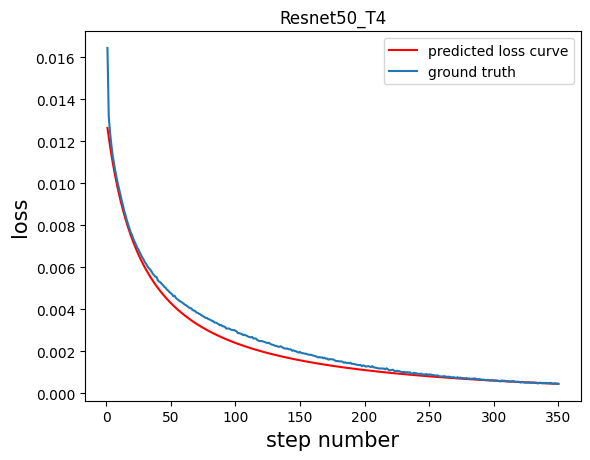

In [23]:
# plt.figure(figsize = (10,8))
plt.plot(np.arange(1, 351), y_predict[0, :], c='red', label="predicted loss curve")
plt.plot(range(1, 1+len(resnet50_t4)), resnet50_t4, label='ground truth')
plt.ylabel('loss', size=15)
plt.xlabel('step number', size=15)
plt.title('Resnet50_T4')
plt.legend()
plt.show()

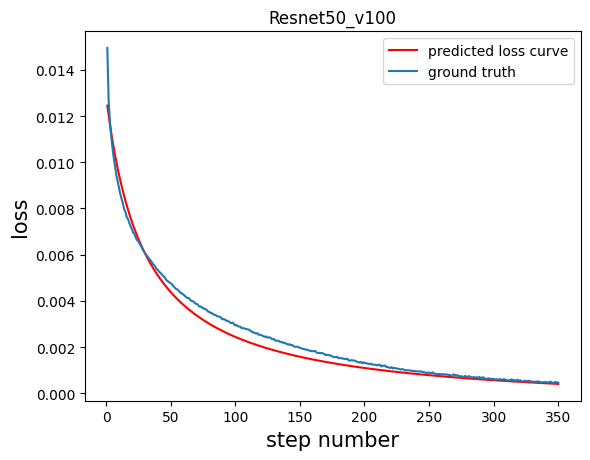

In [24]:
# plt.figure(figsize = (10,8))
plt.plot(np.arange(1, 351), y_predict[1, :], c='red', label="predicted loss curve")
plt.plot(range(1, 1+len(resnet50_v100)), resnet50_v100, label='ground truth')
plt.ylabel('loss', size=15)
plt.xlabel('step number', size=15)
plt.title('Resnet50_v100')
plt.legend()
plt.show()

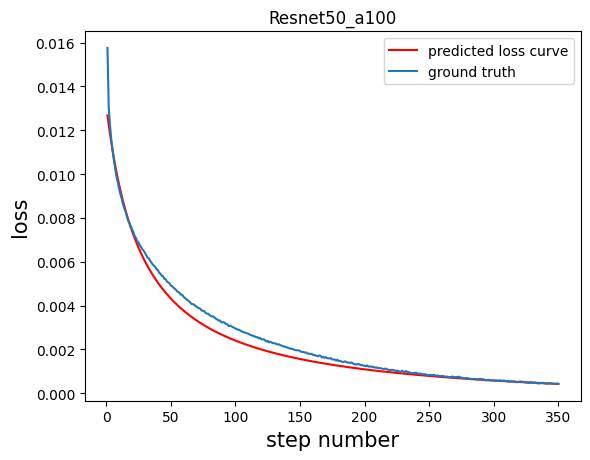

In [25]:
plt.plot(np.arange(1, 351), y_predict[2, :], c='red', label="predicted loss curve")
plt.plot(range(1, 1+len(resnet50_a100)), resnet50_a100, label='ground truth')
plt.ylabel('loss', size=15)
plt.xlabel('step number', size=15)
plt.title('Resnet50_a100')
plt.legend()
plt.show()

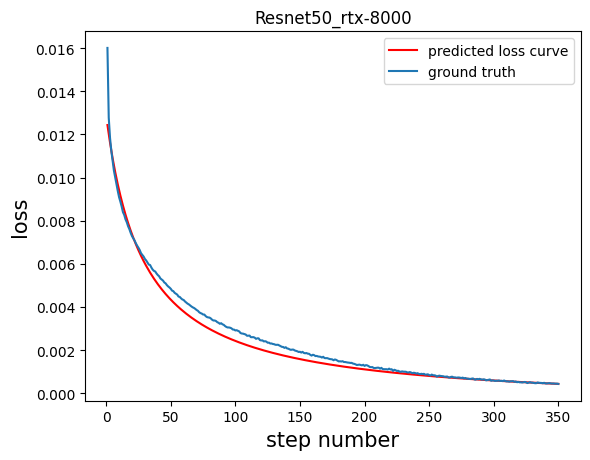

In [26]:
plt.plot(np.arange(1, 351), y_predict[3, :], c='red', label="predicted loss curve")
plt.plot(range(1, 1+len(resnet50_rtx8000)), resnet50_rtx8000, label='ground truth')
plt.ylabel('loss', size=15)
plt.xlabel('step number', size=15)
plt.title('Resnet50_rtx-8000')
plt.legend()
plt.show()

In [27]:
print(f'loss at accuracy of 92% for resnet50 with t4 GPU was {resnet50_t4[acc_index_t4[0][0]]} and occured at step {acc_index_t4[0][0]}')
print(f'loss at accuracy of 92% for resnet50 with v-100 GPU was {resnet50_v100[acc_index_v100[0][0]]} and occured at step {acc_index_v100[0][0]}')
print(f'loss at accuracy of 92% for resnet50 with a100 GPU was {resnet50_a100[acc_index_a100[0][0]]} and occured at step {acc_index_a100[0][0]}')
print(f'loss at accuracy of 92% for resnet50 with rtx8000 GPU was {resnet50_rtx8000[acc_index_rtx8000[0][0]]} and occured at step {acc_index_rtx8000[0][0]}')

loss at accuracy of 92% for resnet50 with t4 GPU was 0.001885782086700201 and occured at step 153
loss at accuracy of 92% for resnet50 with v-100 GPU was 0.0018987423665821552 and occured at step 153
loss at accuracy of 92% for resnet50 with a100 GPU was 0.001878564138263464 and occured at step 152
loss at accuracy of 92% for resnet50 with rtx8000 GPU was 0.0019121351626515389 and occured at step 148


In [28]:
loss_index_t4 = np.nonzero(y_predict_rounded[0, :] == 0.0018)
loss_index_v100 = np.nonzero(y_predict_rounded[1, :] == 0.0018)
loss_index_a100 = np.nonzero(y_predict_rounded[2, :] == 0.0018)
loss_index_rtx8000 = np.nonzero(y_predict_rounded[3, :] == 0.0019)

In [29]:
print(f"the predicted step for achieving accuracy 92% with resnet50 and T4 GPU is", loss_index_t4[0][0])
print(f"the predicted step for achieving accuracy 92% with resnet50 and V100 GPU is", loss_index_v100[0][0])
print(f"the predicted step for achieving accuracy 92% with resnet50 and A100 GPU is", loss_index_a100[0][0])
print(f"the predicted step for achieving accuracy 92% with resnet50 and Rtx-8000 GPU is", loss_index_rtx8000[0][0])

the predicted step for achieving accuracy 92% with resnet50 and T4 GPU is 129
the predicted step for achieving accuracy 92% with resnet50 and V100 GPU is 130
the predicted step for achieving accuracy 92% with resnet50 and A100 GPU is 129
the predicted step for achieving accuracy 92% with resnet50 and Rtx-8000 GPU is 124


# Results

In [30]:
# Calculating the mean square error 
import sklearn.metrics
error_t4 = sklearn.metrics.mean_squared_error(resnet50_t4, y_predict[0, :])
error_v100 = sklearn.metrics.mean_squared_error(resnet50_v100, y_predict[1, :])
error_a100 = sklearn.metrics.mean_squared_error(resnet50_a100, y_predict[2, :])
error_rtx8000 = sklearn.metrics.mean_squared_error(resnet50_rtx8000, y_predict[3, :])

In [31]:
print(f'mse for T4: {error_t4}')
print(f'mse for v_100: {error_v100}')
print(f'mse for a-100: {error_a100}')
print(f'mse for rtx_8000: {error_rtx8000}')

mse for T4: 1.4732901825330787e-07
mse for v_100: 1.1899344892383453e-07
mse for a-100: 1.4380714814446485e-07
mse for rtx_8000: 1.2498634084052863e-07


In [32]:
# calculating the percentage error in predicting the step in which we reach 92% accuracy
print (f'the percentage error for T4 is {(153 - 132) / 153}')
print (f'the percentage error for V100 is {(153 - 129) / 153}')
print (f'the percentage error for A100 is {(152 - 129) / 152}')
print (f'the percentage error for RTX8000 is {(148 - 123) / 148}')

the percentage error for T4 is 0.13725490196078433
the percentage error for V100 is 0.1568627450980392
the percentage error for A100 is 0.1513157894736842
the percentage error for RTX8000 is 0.16891891891891891


In [33]:
def training_speed(p, w, M):
    return 1 / (1.02 * (M / w) + 2.78 + (4.92 * ( w / p)) + (0.02 * p))

In [34]:

worker = np.arange(1, 32)
training_speed_two = []
training_speed_four = []
for w in worker:
    time_twoPS = training_speed(2, w, (128))
    time_fourPS = training_speed(4, w, (128))
    training_speed_two.append(time_twoPS)
    training_speed_four.append(time_fourPS)

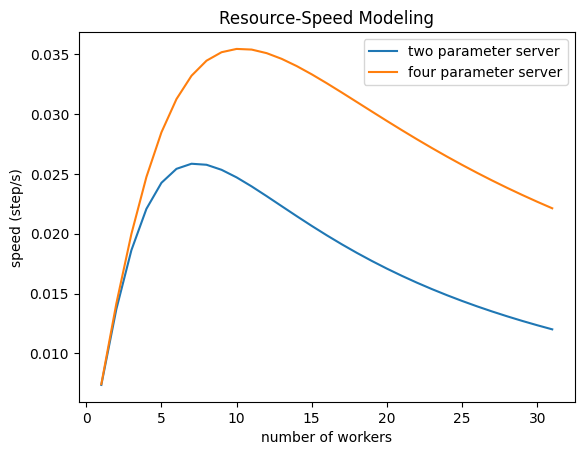

In [35]:
plt.plot(worker, training_speed_two, label= 'two parameter server' )
plt.plot(worker, training_speed_four, label= 'four parameter server' )
plt.xlabel('number of workers')
plt.ylabel('speed (step/s)')
plt.title("Resource-Speed Modeling")
plt.legend()
plt.show()

In [36]:
def train_time(PS):
    resnet50_rtx8000_time = []
    resnet50_v100_time = []
    resnet50_a100_time = []
    resnet50_t4_time = []
    for i in PS:
        resnet50_t4_time.append(132 / i)
        resnet50_rtx8000_time.append(123 / i)
        resnet50_v100_time.append(129 / i)
        resnet50_a100_time.append(129 / i)
    
    resnet50_rtx8000_time = np.asarray(resnet50_rtx8000_time)
    resnet50_v100_time = np.asarray(resnet50_v100_time)
    resnet50_a100_time = np.asarray(resnet50_a100_time)
    resnet50_t4_time =np.asarray(resnet50_t4_time)
    return [resnet50_rtx8000_time, resnet50_v100_time, resnet50_a100_time, resnet50_t4_time]
    
    

In [37]:
data = train_time(training_speed_two)

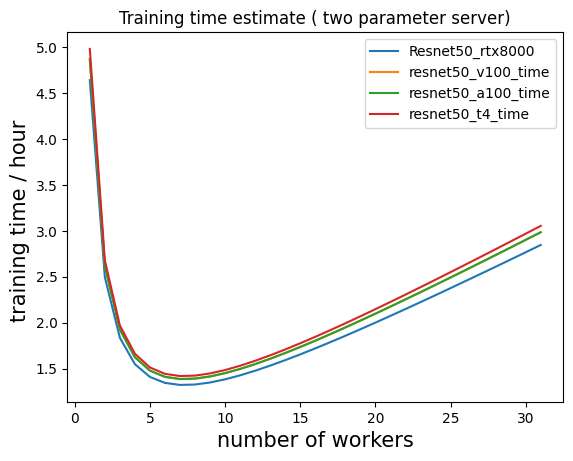

In [38]:
plt.plot(worker, data[0] / 3600, label= 'Resnet50_rtx8000' )
plt.plot(worker, data[1] / 3600, label= 'resnet50_v100_time' )
plt.plot(worker, data[2] / 3600, label= 'resnet50_a100_time' )
plt.plot(worker, data[3] / 3600, label= 'resnet50_t4_time' )
plt.xlabel('number of workers', size = 15)
plt.ylabel('training time / hour ', size = 15)
plt.title("Training time estimate ( two parameter server)")
plt.legend()
plt.show()

In [40]:
data = train_time(training_speed_four)

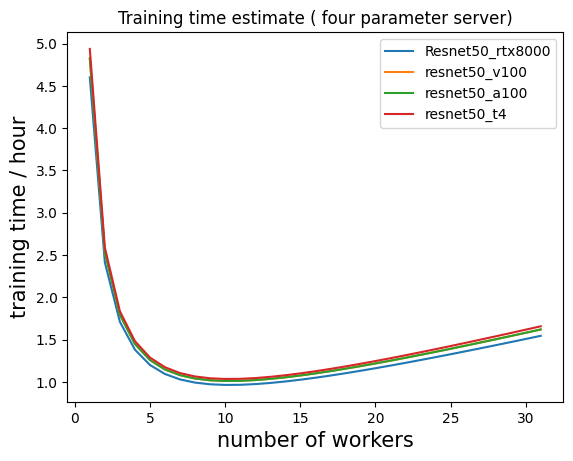

In [41]:
plt.plot(worker, data[0] / 3600, label= 'Resnet50_rtx8000' )
plt.plot(worker, data[1] / 3600, label= 'resnet50_v100' )
plt.plot(worker, data[2] / 3600, label= 'resnet50_a100' )
plt.plot(worker, data[3] / 3600, label= 'resnet50_t4' )
plt.xlabel('number of workers', size=15)
plt.ylabel('training time / hour', size=15)
plt.title("Training time estimate ( four parameter server)")
plt.legend()
plt.show()

### convergence curve with high GPU utilization

In [42]:
resnet110_v100_b1024 = torch.load('./loss/v100_resnet110_train_losses_b1024.pth', map_location=torch.device('cpu'))
resnet110_a100_b2048 = torch.load('./experiment_2/a100_resnet110_train_losses_b2048.pth', map_location=torch.device('cpu'))
resnet110_rtx_b2048 = torch.load('./experiment_2/rtx8000_resnet110_train_losses_b2048.pth', map_location=torch.device('cpu'))

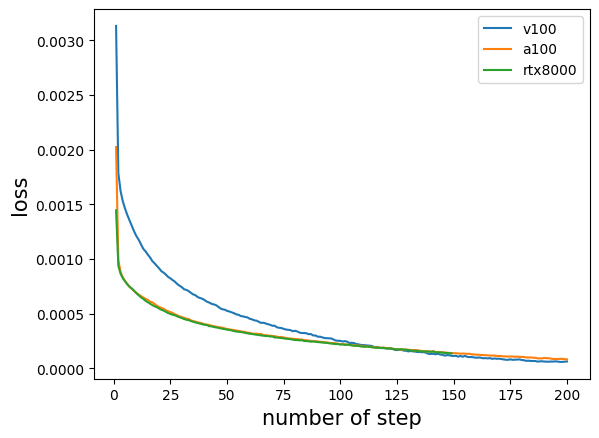

In [44]:
plt.plot(np.arange(1, len(resnet110_v100_b1024) + 1), resnet110_v100_b1024, label='v100')
plt.plot(np.arange(1, len(resnet110_a100_b2048) + 1), resnet110_a100_b2048, label='a100')
plt.plot(np.arange(1, len(resnet110_rtx_b2048) + 1), resnet110_rtx_b2048, label='rtx8000')
plt.xlabel('number of step', size=15)
plt.ylabel('loss', size=15)
plt.legend()
plt.show()